Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from glob import glob

In [3]:
# warnings

import warnings
warnings.filterwarnings('ignore')

In [4]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip /content/gdrive/MyDrive/CNN_assignment.zip

Archive:  /content/gdrive/MyDrive/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
## Added for test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=123,
    batch_size=118,
    image_size=(img_height,img_width)
)

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
# Printing the no of classes just to recheck
print(len(class_names))

9


In [14]:
#Validation classes
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Visualize the data

Todo, create a code to visualize one instance of all the nine classes present in the dataset

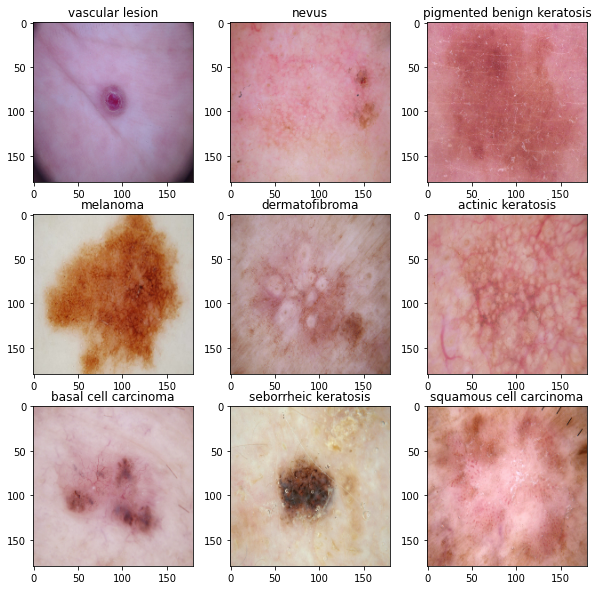

In [15]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
# To make sure all classes are included, added the visited flag
plot_idx=0
visited={}
visited_all=False
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(50):
  if not visited_all:
    for i in range(9):
      if len(visited.keys())==9:
        visited_all=True
        break
      if class_names[labels[i]] in visited.keys():
        continue
      else:
        plt.subplot(3,3,plot_idx+1)
        plt.imshow(images[i].numpy().astype("uint8"));
        plt.title(class_names[labels[i]])
        visited[class_names[labels[i]]]="Y"
        plot_idx+=1
  else:
    break

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model

Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [17]:
### Your code goes here
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

Compile the model


Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

Train the model

In [20]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 27s 89ms/step - loss: 2.0487 - accuracy: 0.2121 - val_loss: 1.9865 - val_accuracy: 0.3647
Epoch 2/30
56/56 [==============================] - 2s 42ms/step - loss: 1.7725 - accuracy: 0.3566 - val_loss: 1.7190 - val_accuracy: 0.3803
Epoch 3/30
56/56 [==============================] - 2s 40ms/step - loss: 1.6580 - accuracy: 0.3940 - val_loss: 1.6014 - val_accuracy: 0.4564
Epoch 4/30
56/56 [==============================] - 2s 40ms/step - loss: 1.5401 - accuracy: 0.4492 - val_loss: 1.5337 - val_accuracy: 0.4541
Epoch 5/30
56/56 [==============================] - 2s 40ms/step - loss: 1.4692 - accuracy: 0.4794 - val_loss: 1.4603 - val_accuracy: 0.4787
Epoch 6/30
56/56 [==============================] - 2s 40ms/step - loss: 1.4357 - accuracy: 0.4877 - val_loss: 1.4748 - val_accuracy: 0.4519
Epoch 7/30
56/56 [==============================] - 2s 41ms/step - loss: 1.3816 - accuracy: 0.5167 - val_loss: 1.5571 - val_accuracy: 0.4609
Epoch 8/30
5

Visualizing training results

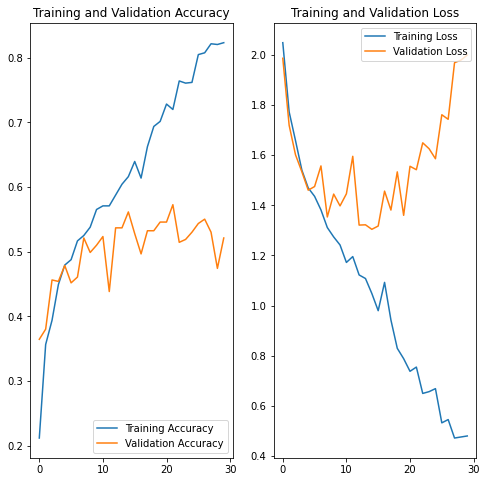

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Till about the 10th epoch, both validation and train accuracy were increasing after which the train acuracy increased but not the validation accuracy as such. This means that the model has started to overfit.

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

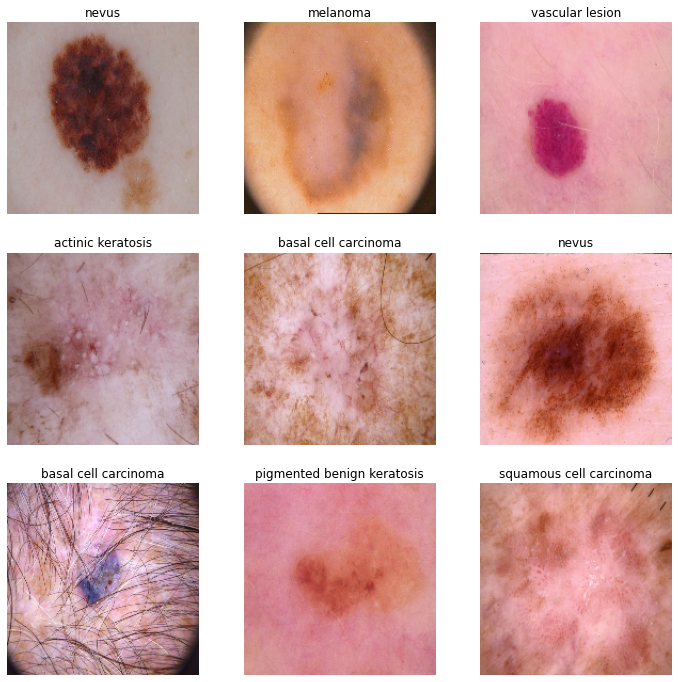

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Todo:

Create the model, compile and train the model

In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
model = Sequential([data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

Compiling the model

In [25]:
## Your code goes here
## Your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

Training the model

In [26]:
## Your code goes here, note: train your model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 48ms/step - loss: 2.0597 - accuracy: 0.1931 - val_loss: 2.0995 - val_accuracy: 0.3289
Epoch 2/30
56/56 [==============================] - 2s 44ms/step - loss: 1.9478 - accuracy: 0.2790 - val_loss: 1.8127 - val_accuracy: 0.3960
Epoch 3/30
56/56 [==============================] - 3s 50ms/step - loss: 1.6529 - accuracy: 0.4007 - val_loss: 1.7638 - val_accuracy: 0.3937
Epoch 4/30
56/56 [==============================] - 3s 52ms/step - loss: 1.5899 - accuracy: 0.4235 - val_loss: 1.6533 - val_accuracy: 0.3803
Epoch 5/30
56/56 [==============================] - 3s 50ms/step - loss: 1.5545 - accuracy: 0.4280 - val_loss: 1.5774 - val_accuracy: 0.4362
Epoch 6/30
56/56 [==============================] - 3s 45ms/step - loss: 1.4702 - accuracy: 0.4727 - val_loss: 1.5451 - val_accuracy: 0.4497
Epoch 7/30
56/56 [==============================] - 2s 44ms/step - loss: 1.4832 - accuracy: 0.4710 - val_loss: 1.4916 - val_accuracy: 0.4743
Epoch 8/30
56

Visualizing the results

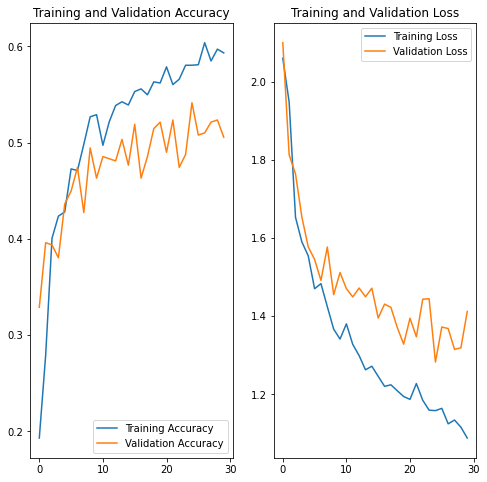

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

This time we can see overfitting has reduced but the model performance is not very good.

In [28]:
# Trying some other combinations

In [29]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
### Your code goes here
model = Sequential([data_aug,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

In [30]:
## Your code goes here

model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [31]:
## Your code goes here, note: train your model for 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 3s 44ms/step - loss: 2.0064 - accuracy: 0.2349 - val_loss: 1.9161 - val_accuracy: 0.3356
Epoch 2/30
56/56 [==============================] - 2s 40ms/step - loss: 1.7825 - accuracy: 0.3415 - val_loss: 1.6824 - val_accuracy: 0.3893
Epoch 3/30
56/56 [==============================] - 2s 40ms/step - loss: 1.6442 - accuracy: 0.4062 - val_loss: 1.7914 - val_accuracy: 0.3960
Epoch 4/30
56/56 [==============================] - 2s 40ms/step - loss: 1.5987 - accuracy: 0.4252 - val_loss: 1.5752 - val_accuracy: 0.4698
Epoch 5/30
56/56 [==============================] - 2s 41ms/step - loss: 1.5365 - accuracy: 0.4436 - val_loss: 1.5422 - val_accuracy: 0.4541
Epoch 6/30
56/56 [==============================] - 2s 41ms/step - loss: 1.4987 - accuracy: 0.4565 - val_loss: 1.4962 - val_accuracy: 0.4765
Epoch 7/30
56/56 [==============================] - 2s 40ms/step - loss: 1.4793 - accuracy: 0.4821 - val_loss: 1.4606 - val_accuracy: 0.5078
Epoch 8/30
56

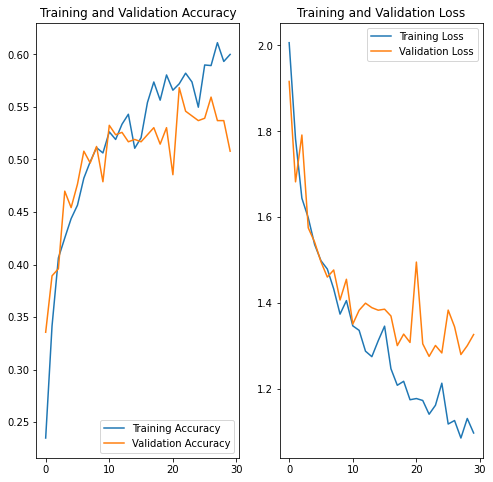

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
## Your code goes here. 
train_path_list = list(data_dir_train.glob('*/*.jpg'))
train_path_list

[PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0027753.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0028499.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0031738.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0030953.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0025069.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0029067.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0031043.jpg'),
 PosixPath('Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/ISIC_0030986.jpg'),
 PosixPa

In [34]:
#Selecting only the name of the class from the whole path
df=pd.DataFrame({"cancer_type":[str(x).split("/")[2] for x in train_path_list]})
df

,cancer_type
0,squamous cell carcinoma
1,squamous cell carcinoma
2,squamous cell carcinoma
3,squamous cell carcinoma
4,squamous cell carcinoma
...,...
2234,vascular lesion
2235,vascular lesion
2236,vascular lesion
2237,vascular lesion


In [35]:
df['cancer_type'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: cancer_type, dtype: int64

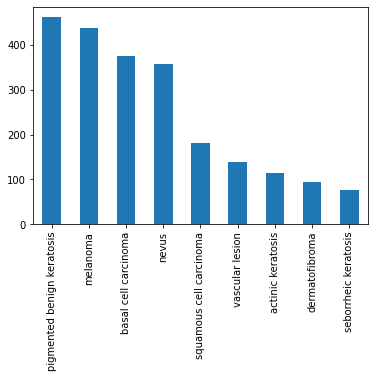

In [36]:
# Barplot to see the counts
df['cancer_type'].value_counts().plot(kind='bar')
plt.show()



```
# This is formatted as code
```



Todo: Write your findings here:
- Which class has the least number of samples?
- Which classes dominate the data in terms proportionate number of samples?

Answers
- seborrheic keratosis has the least number of samples
- pigmented benign keratosis and melanoma dominate the data.

Todo: Rectify the class imbalance

Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [37]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1.Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2.Define a number of operations to perform on this data set using your Pipeline object.
3.Execute these operations by calling the Pipeline’s sample() method.

In [38]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7247C1D90>: 100%|██████████| 500/500 [00:17<00:00, 28.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7246EEC10>: 100%|██████████| 500/500 [00:20<00:00, 23.98 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF724733A50>: 100%|██████████| 500/500 [00:21<00:00, 22.92 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF7247207D0>: 100%|██████████| 500/500 [01:44<00:00,  4.81 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FF7246D3550>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF73A16AA50>: 100%|██████████| 500/500 [00:16<00:00, 30.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF7248B2250>: 100%|██████████| 500/500 [00:41<00:00, 12.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF72434E690>: 100%|██████████| 500/500 [00:16<00:00, 31.09 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF7248FBA90>: 100%|██████████| 500/500 [00:16<00:00, 30.76 Samples/s]


In [39]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [40]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026872.jpg_d239d90e-9ff1-4459-8eec-7f2083eac542.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031044.jpg_48d03e17-d6f2-4644-9adf-6d7facccacfb.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0027767.jpg_4ed0c202-18f8-4451-9012-ae25584e8b30.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025411.jpg_5ef4b4c4-aa66-444c-b055-961cba5bd5a7.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025331.jpg_6ae6e6db-c48c-44d3-bcc7-734b7e575716.jpg',
 'Skin cancer ISIC The Interna

In [41]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [43]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df = original_df.append(df2)

In [44]:
# new_df['Label'].value_counts()
df2['Label'].value_counts()

squamous cell carcinoma       500
seborrheic keratosis          500
basal cell carcinoma          500
actinic keratosis             500
pigmented benign keratosis    500
dermatofibroma                500
nevus                         500
melanoma                      500
vascular lesion               500
Name: Label, dtype: int64

In [45]:
#new counts
new_list=list(df['cancer_type'].values)
new_list.extend(list(df2['Label'].values))
len(new_list)
final_df=pd.DataFrame({"cancer_type":new_list})
final_df['cancer_type'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: cancer_type, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180

Todo: Create a training dataset

In [47]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Todo: Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Todo: Create your model (make sure to include normalization)

In [49]:
## your code goes here
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))
])

Todo: Compile your model (Choose optimizer and loss function appropriately)

In [50]:
## your code goes here
## your code goes here
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

Todo: Train your model

In [51]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 25s 143ms/step - loss: 2.1881 - accuracy: 0.1586 - val_loss: 1.9800 - val_accuracy: 0.2829
Epoch 2/50
169/169 [==============================] - 24s 137ms/step - loss: 1.7470 - accuracy: 0.3346 - val_loss: 1.6203 - val_accuracy: 0.4187
Epoch 3/50
169/169 [==============================] - 24s 139ms/step - loss: 1.5563 - accuracy: 0.4089 - val_loss: 1.5206 - val_accuracy: 0.4395
Epoch 4/50
169/169 [==============================] - 24s 138ms/step - loss: 1.3979 - accuracy: 0.4705 - val_loss: 1.4474 - val_accuracy: 0.4722
Epoch 5/50
169/169 [==============================] - 24s 138ms/step - loss: 1.2869 - accuracy: 0.5056 - val_loss: 1.2678 - val_accuracy: 0.5382
Epoch 6/50
169/169 [==============================] - 24s 140ms/step - loss: 1.1865 - accuracy: 0.5471 - val_loss: 1.2363 - val_accuracy: 0.5509
Epoch 7/50
169/169 [==============================] - 24s 137ms/step - loss: 1.1142 - accuracy: 0.5703 - val_loss: 1.1610 - val_ac

Todo: Visualize the model results

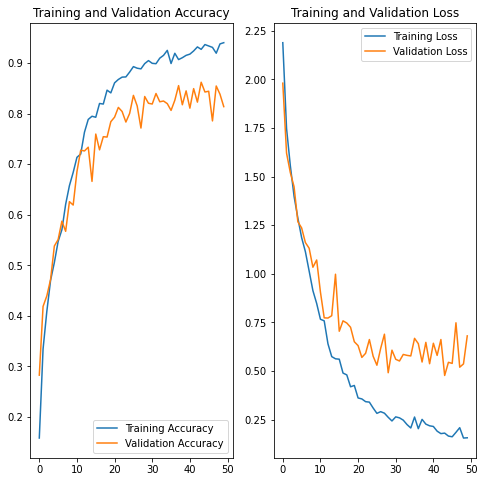

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

The accuracy has improved drastically. We also were able to overcome the problem of overfitting by a significant amount. Handling class imbalance also did help.

We could try and change the hyperparamters to see if the performance can be further enhanced.

In [53]:
#Trying with only 1 dropout layer at the end.

## your code goes here
model_1_dp = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)),
                    #first conv 2d layer
                    Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    
                    Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'),
                    #maxpooling layer
                    MaxPool2D(pool_size = (2, 2)),
                    #droput regularisation
                    Dropout(0.25),
                    Flatten(),
                    Dense(128,activation='relu'),
                    Dense(len(class_names))

])

In [54]:
model_1_dp.summary()
model_1_dp.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 45, 45, 64)       

In [60]:
epochs = 100
## Your code goes here, use 100 epochs.
history = model_1_dp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
169/169 [==============================] - 27s 151ms/step - loss: 0.1059 - accuracy: 0.9534 - val_loss: 0.6423 - val_accuracy: 0.8530
Epoch 2/100
169/169 [==============================] - 25s 141ms/step - loss: 0.1206 - accuracy: 0.9514 - val_loss: 0.7053 - val_accuracy: 0.8374
Epoch 3/100
169/169 [==============================] - 25s 141ms/step - loss: 0.1277 - accuracy: 0.9479 - val_loss: 0.7717 - val_accuracy: 0.8293
Epoch 4/100
169/169 [==============================] - 25s 141ms/step - loss: 0.1737 - accuracy: 0.9388 - val_loss: 0.7825 - val_accuracy: 0.8241
Epoch 5/100
169/169 [==============================] - 24s 140ms/step - loss: 0.1103 - accuracy: 0.9542 - val_loss: 0.5746 - val_accuracy: 0.8575
Epoch 6/100
169/169 [==============================] - 25s 142ms/step - loss: 0.0963 - accuracy: 0.9596 - val_loss: 0.6514 - val_accuracy: 0.8537
Epoch 7/100
169/169 [==============================] - 25s 141ms/step - loss: 0.0938 - accuracy: 0.9572 - val_loss: 0.6229 -

In [61]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(118, 180, 180, 3)
(118,)


In [63]:
img = tf.keras.utils.load_img(
    '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000002.jpg', target_size=(img_height, img_width)
)

In [64]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [65]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dermatofibroma with a 99.98 percent confidence.
